In [ ]:
#Cài đặt thư viện
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.style.use("ggplot")
import numpy as np 
import pandas as pd 
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [ ]:
#Data mining
def data_mining(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  result = seasonal_decompose(data, model='additive', period=20)
  #chuyển giá trị trên trục x nghiêng 45 độ
  result.observed.index = result.observed.index.strftime('%d-%m-%Y')
  #Tạo 4 subplots
  fig, ax = plt.subplots(4, 1, figsize=(10, 8))
  #Thực hiện gắn dữ liệu vào từng subplot
  result.observed.plot(ax=ax[0])
  ax[0].set_ylabel('Observed')
  result.trend.plot(ax=ax[1])
  ax[1].set_ylabel('Trend')
  result.seasonal.plot(ax=ax[2])
  ax[2].set_ylabel('Seasonal')
  result.resid.plot(ax=ax[3])
  ax[3].set_ylabel('Residual')
  plt.tight_layout()
  plt.show()

In [ ]:
#Chuẩn hóa dữ liệu
def data_scaling(df):
  scaler=MinMaxScaler()
  df1=scaler.fit_transform(np.array(df).reshape(-1,1))
  return df1, scaler

In [ ]:
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [ ]:
#Chia dữ liệu
def data_spliting(df1, train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))
  val_size = len(df1) - train_size - test_size

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]
  val_data = df1[train_size+test_size:]

  return train_data, test_data, val_data

In [ ]:
def next30days(regressor, scaler ,val_label_inverse, val_data_df, time_step):
  next30days_index=pd.date_range(val_data_df[-1:].index.date[0],periods = 30 ,freq='D')
  pred_next = np.array([])
  val_label_inverse=val_label_inverse[-time_step:].reshape(1,-1).reshape(1,time_step)
  for i in range(30):
    y_pred_next = regressor.predict(val_label_inverse.reshape(1,-1).reshape(1,time_step))
    val_label_inverse = np.append(val_label_inverse,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])
    
  next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)), index = next30days_index)
  return next30days_predict_inverse

In [ ]:
#Huấn luyện
def random_forest_fit(X_train, y_train,X_test, y_test,X_val, y_val, time_step, scaler, train_data_df, test_data_df, val_data_df, model_name):
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.model_selection import RandomizedSearchCV

  n_estimators = [5,20,50,100] # number of trees in the random forest
  max_features = ['auto', 'sqrt'] # number of features in consideration at every split
  max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
  min_samples_split = [2, 6, 10] # minimum sample number to split a node
  min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
  bootstrap = [True, False] # method used to sample data points

  random_grid = {'n_estimators': n_estimators,

  'max_features': max_features,

  'max_depth': max_depth,

  'min_samples_split': min_samples_split,

  'min_samples_leaf': min_samples_leaf,

  'bootstrap': bootstrap}


  regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = random_grid,
                n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

  regressor.fit(X_train.reshape(X_train.shape[0],time_step), y_train.reshape(y_train.shape[0],))

  #dự đoán tập test
  test_predict=regressor.predict(X_test.reshape(X_test.shape[0],time_step))

  test_predict_inverse = scaler.inverse_transform(test_predict.reshape(-1,1))
  test_label_inverse = scaler.inverse_transform(y_test.reshape(-1,1))
  deviation(test_label_inverse, test_predict_inverse)
  test_predict_inverse = pd.DataFrame(test_predict_inverse, index = test_data_df[(time_step+1):].index)
  test_label_inverse = pd.DataFrame(test_label_inverse, index = test_data_df[(time_step+1):].index)
  visualize(test_label_inverse, test_predict_inverse, model_name)

  #dự đoán tập validate
  val_predict=regressor.predict(X_val.reshape(X_val.shape[0],time_step))

  val_predict_inverse =scaler.inverse_transform(val_predict.reshape(-1,1))
  val_label_inverse = scaler.inverse_transform(y_val.reshape(-1,1))
  deviation(val_label_inverse, val_predict_inverse)
  val_predict_inverse = pd.DataFrame(val_predict_inverse, index = val_data_df[(time_step+1):].index)
  val_label_inverse = pd.DataFrame(val_label_inverse, index = val_data_df[(time_step+1):].index)
  
  visualize(val_label_inverse, val_predict_inverse, model_name)



  next30_predict_inverse = next30days(regressor, scaler , y_val, val_data_df, time_step)
  visualize_overview(train_data_df, test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, next30_predict_inverse, model_name)

In [ ]:
def visualize(label ,pred, model_name):
  plt.figure(figsize=(16,9))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [ ]:
#Visualization
def visualize_overview(train_data_df,test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, next30_predict_inverse, model_name):

  plt.figure(figsize=(16,9))
  #train label
  plt.plot(train_data_df, label = 'Train')

  #test label and predict value
  plt.plot(test_data_df, label = 'Test')
  plt.plot(test_predict_inverse, label='Predict')

  #val label and predict value
  plt.plot(val_data_df, label = 'Validate')
  plt.plot(val_predict_inverse, label='ValidatePred')

  #predict next 30 days value
  # plt.plot(next30_predict_inverse, label = 'Predict30days')


  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [ ]:
def mda_cal(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

In [ ]:
#Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mda = mda_cal(test, pred)
  print(f"MDA: {mda*100:.2f}%")

In [ ]:
#Chọn dataset, tỉ lệ và 
def data_preprocessing(data_src, train_ratio, test_ratio, time_step, model_name):
  df = pd.read_csv(data_src, parse_dates=True,
                       index_col=0).sort_values(by='Date', ascending=True)
  #Xóa dấu , và chuyển về float
  df['Price']=df['Price'].replace(',','',regex=True).astype(float)
  df['Open']=df['Open'].astype(str).str.replace(',','').astype(float)
  df['High']=df['High'].astype(str).str.replace(',','').astype(float)
  df['Low']=df['Low'].astype(str).str.replace(',','').astype(float)
  df['Change %']=df['Change %'].astype(str).str.replace('%','').astype(float)

  #Thực hiện tách chuỗi KL thành 1 chuỗi số float và 1 ký tự cuối sau đó lấy số float đó nhân với 1000 
  #nếu ký tự cuối là K, nếu là M thì nhân với 1000000, nếu không có K hay M thì trả về số float đó
  def convert_value(value):
      if isinstance(value, str):
          if value.endswith('K'):
              return float(value[:-1]) * 1000
          elif value.endswith('M'):
              return float(value[:-1]) * 1000000
          else:
              return float(value)
      else:
          return value

  df['Vol.'] = df['Vol.'].apply(convert_value)

  df = df[['Price']]

  data_mining(df)

  df1, scaler = data_scaling(df)
  
  train_data_df, test_data_df, val_data_df = data_spliting(df,train_ratio, test_ratio)
  train_data, test_data, val_data = data_spliting(df1,train_ratio, test_ratio)

  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)
  X_val, y_val = create_dataset(val_data, time_step)

  model =  random_forest_fit(X_train, y_train,X_test, y_test,X_val, y_val, time_step, scaler, train_data_df, test_data_df, val_data_df, model_name)


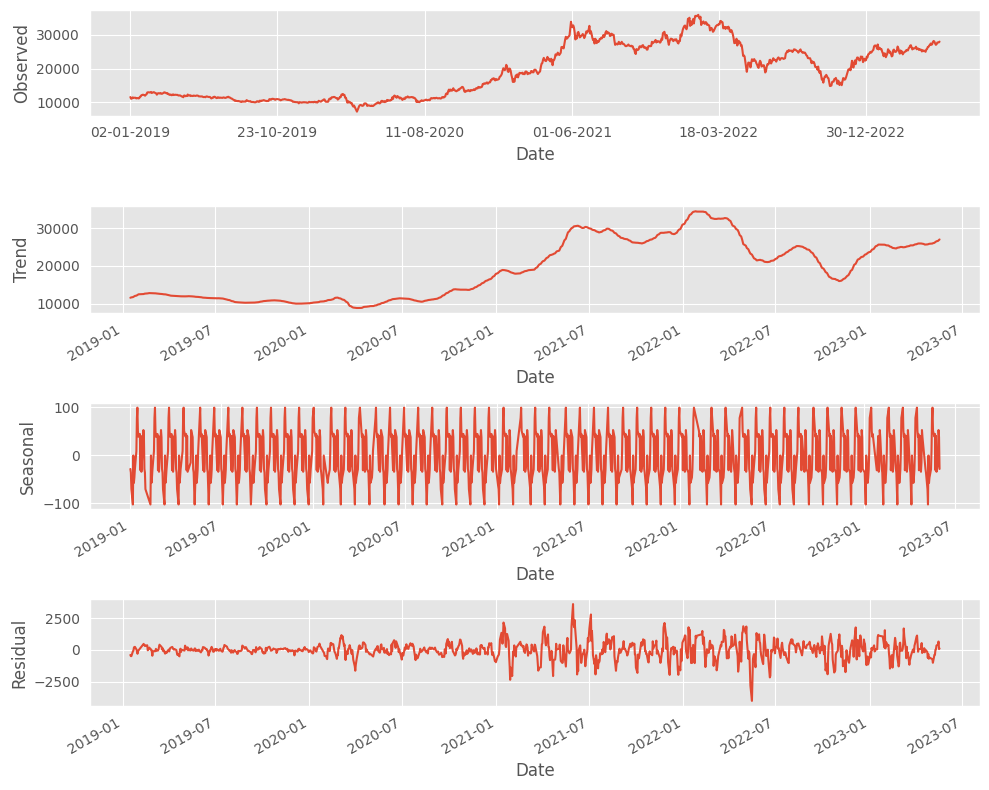

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE: 907.94
MAPE: 3.99%
MDA: 54.41%


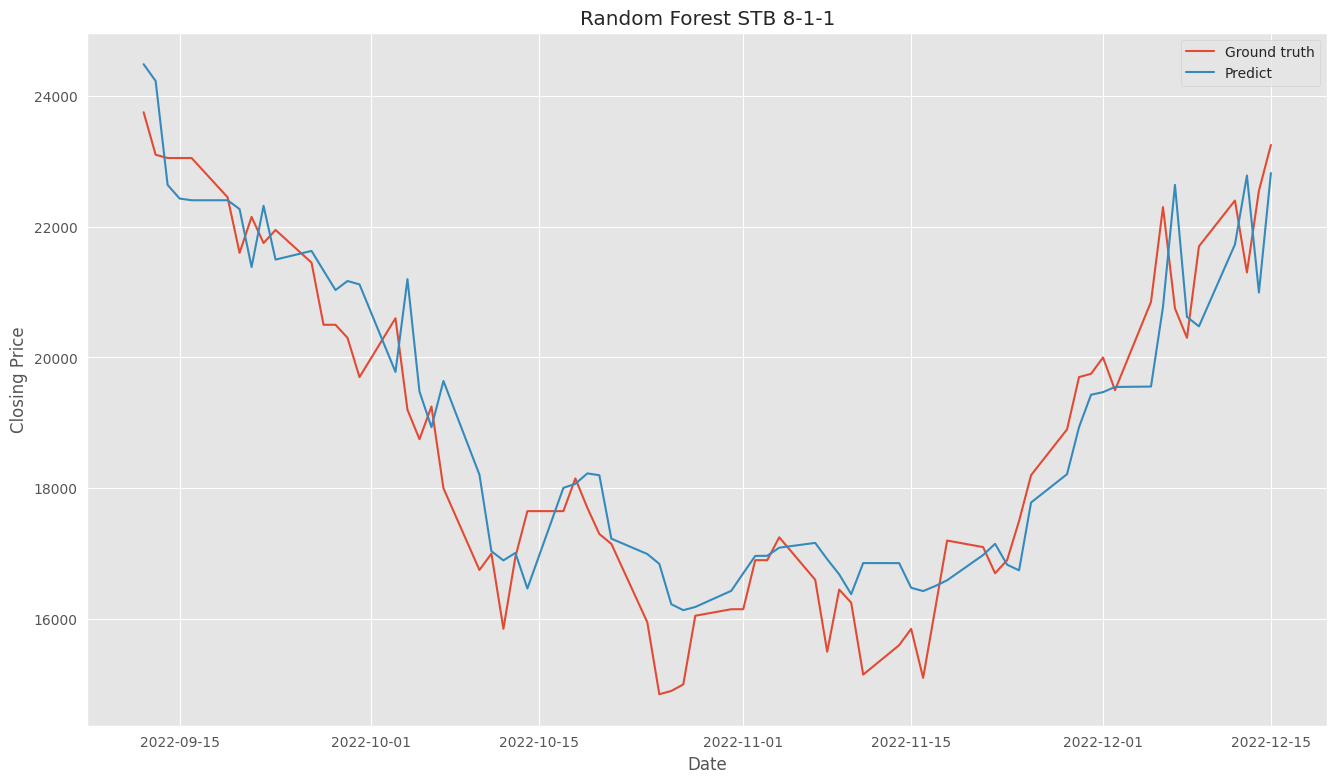

RMSE: 610.75
MAPE: 1.88%
MDA: 57.97%


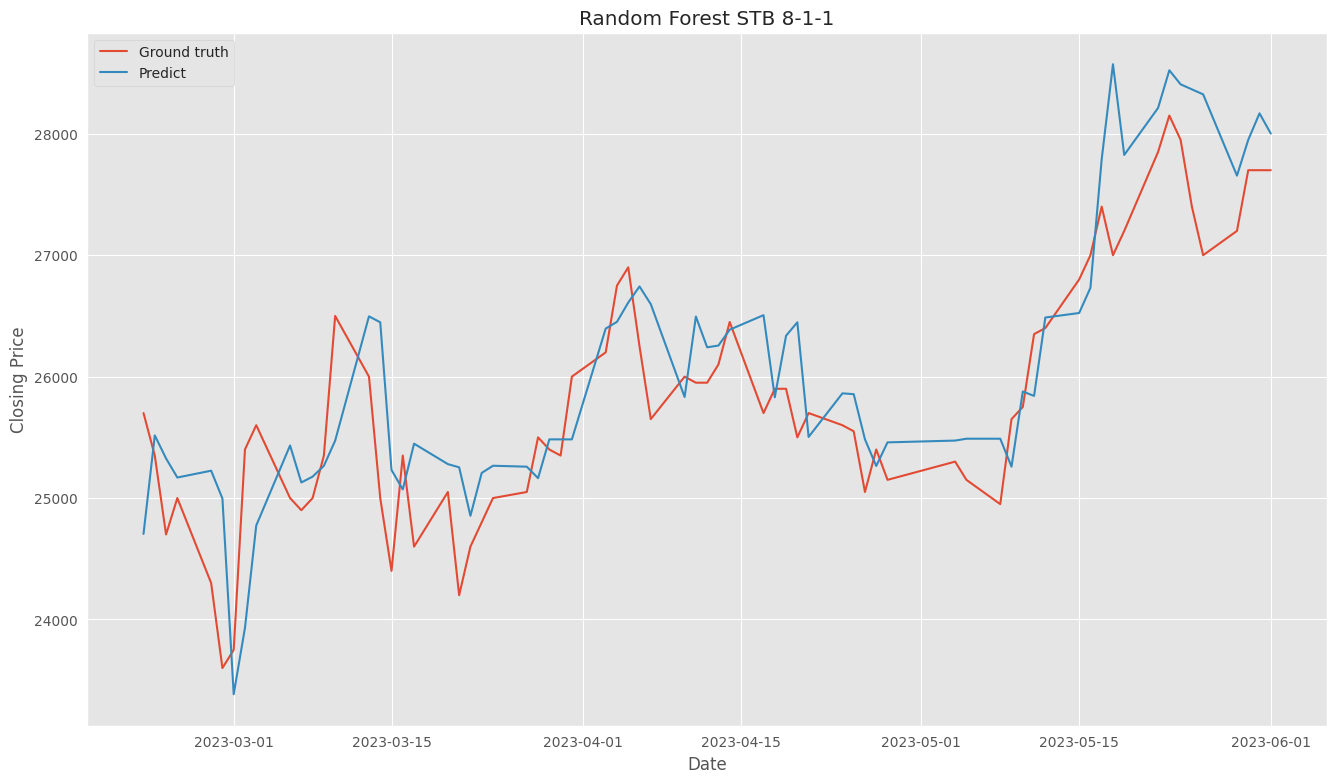

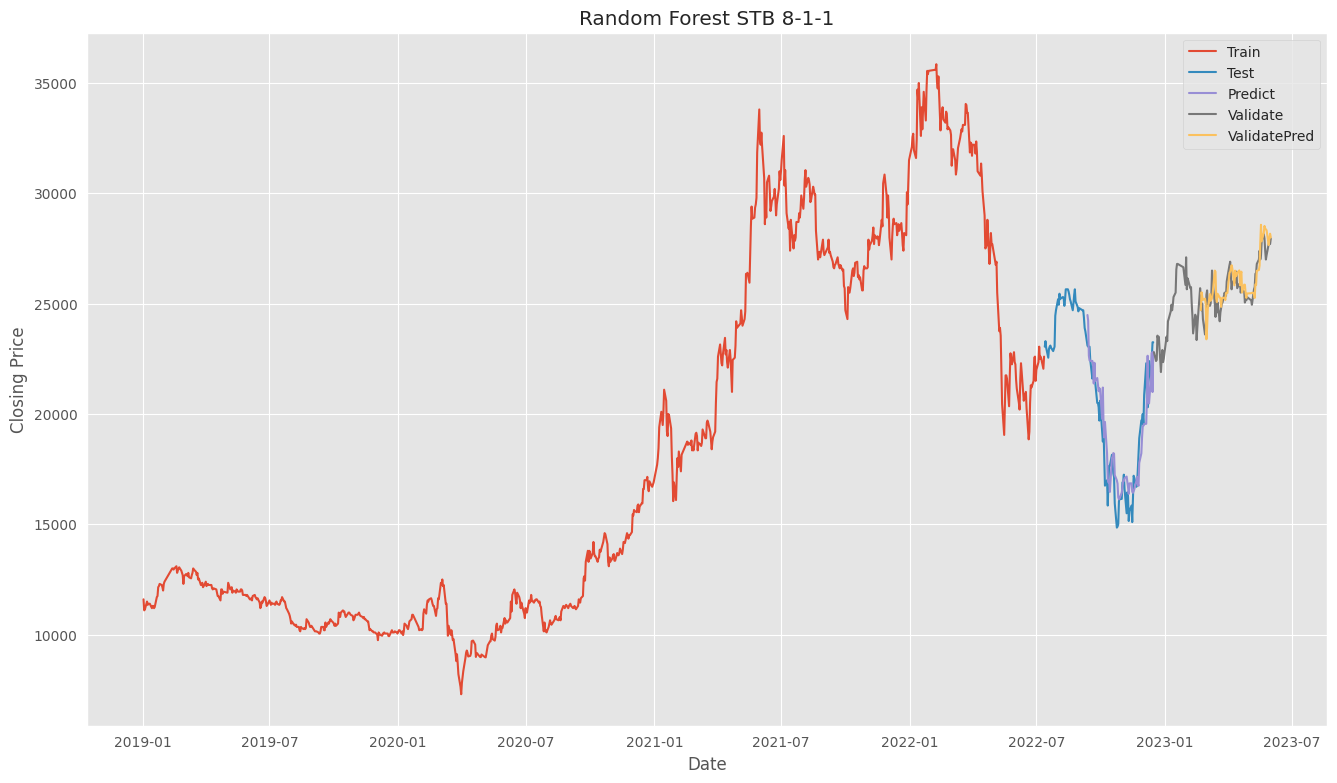

In [ ]:
data_preprocessing('/content/STB Historical Data.csv', 0.8, 0.1, 40, "Random Forest STB 8-1-1")